In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def generate_property():
    """
    E/I: 1, bool
    blocked_in_stat: 1, bool
    I_external_Input: 1, float
    sub_blocak_idx: 1, int
    C: 1, float
    T_ref: 1, float
    g_Li: 1, float
    V_L: 1, float
    V_th: 1, float
    V_reset: 1, float
    g_ui: 4, float
    V_ui: 4, float
    tau_ui: 4, float
    
    total: 22
    """
    
    property = np.zeros((1,22), dtype=np.float32)
    
    
    property[:, 0] = 1 # E/I
    property[:, 1] = 0 # blocked_in_stat
    property[:, 2] = 0 # I_external_Input
    property[:, 3] = 0 # sub_blocak_idx
    property[:, 4] = 1 # C
    property[:, 5] = 5 # T_ref
    property[:, 6] = 0.001 # g_Li
    property[:, 7] = -75 # V_L
    property[:, 8] = -50 # V_th
    property[:, 9] = -65 # V_reset

    property[:, 10:14] = np.array([10/500, 5/6000, 1.5/60, 1/1000]) # g_ui
    property[:, 14:18] = np.array([0, 0, -70, -100]) # V_ui
    property[:, 18:22] = np.array([2, 40, 10, 50]) # tau_ui
    

    return property

In [25]:
class block:
    def __init__(self, node_property, delta_t=1):
        # A block is a set of spliking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
        
        import torch
        
        N = 1
        K = 4
        
        self.delta_t = delta_t
        
        self.I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
        self.sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
        self.C = torch.tensor(node_property[:, 4])   # shape [N]
        self.T_ref = torch.tensor(node_property[:, 5]) # shape [N]
        self.g_Li = torch.tensor(node_property[:, 6])  # shape [N]
        self.V_L = torch.tensor(node_property[:, 7])  # shape [N]        
        self.V_th = torch.tensor(node_property[:, 8])  # shape [N]
        self.V_reset = torch.tensor(node_property[:, 9]) # shape [N]
        self.g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
        self.V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]   

        self.t_ik_last = torch.zeros(N) # shape [N]
        self.active = torch.tensor(False) # bool
        self.V_i = torch.ones(N) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros((K, N))  # shape [K, N]
        self.t = torch.tensor(0.)  # scalar

    def update_J_ui(self, spikes):
        # spikes: num of spike
        
        J_ui_activate_part = torch.ones(4,1) * spikes
        self.J_ui = self.J_ui * torch.exp(-self.delta_t / self.tau_ui)
        self.J_ui += J_ui_activate_part

    def update_t_ik_last(self):
        self.t_ik_last = torch.where(self.active, self.t, self.t_ik_last)

    def update_Vi(self):
        
        I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        I_syn = I_ui.sum(dim=0)
        
        delta_Vi = -self.g_Li * (self.V_i - self.V_L) + I_syn + self.I_extern_Input
        delta_Vi *= self.delta_t / self.C

        Vi_normal = self.V_i + delta_Vi

        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)
        self.V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)
        self.active = self.V_i >= self.V_th
        self.V_i = torch.min(self.V_i, self.V_th)

    def update(self, spikes):
        self.t += self.delta_t
        
        self.update_J_ui(spikes)
        self.update_t_ik_last()
        self.update_Vi()

        return self.t.tolist(), self.V_i.tolist()[0]
    
    def param_show(self):
        print(f'I_extern_Input: {self.I_extern_Input}')
        print(f'sub_idx: {self.sub_idx}')
        print(f'C: {self.C}')
        print(f'T_ref: {self.T_ref}')
        print(f'g_Li: {self.g_Li}')
        print(f'V_L: {self.V_L}')        
        print(f'V_th: {self.V_th}')
        print(f'V_reset: {self.V_reset}')
        print(f'g_ui: {self.g_ui}')
        print(f'V_ui: {self.V_ui}')
        print(f'tau_ui: {self.tau_ui}')  

        print(f't_ik_last: {self.t_ik_last}')
        print(f'active: {self.active}')
        print(f'V_i: {self.V_i}')
        print(f'J_ui: {self.J_ui}')
        print(f't: {self.t}')

In [33]:
t = 100 #ms
sp = torch.poisson(torch.ones(t)*5)
pro = generate_property()
b = block(pro, delta_t=1)

In [35]:
x_out = []
y_out = []
for i in range(t):
    x, y = b.update(sp[i])
    x_out.append(x)
    y_out.append(y)

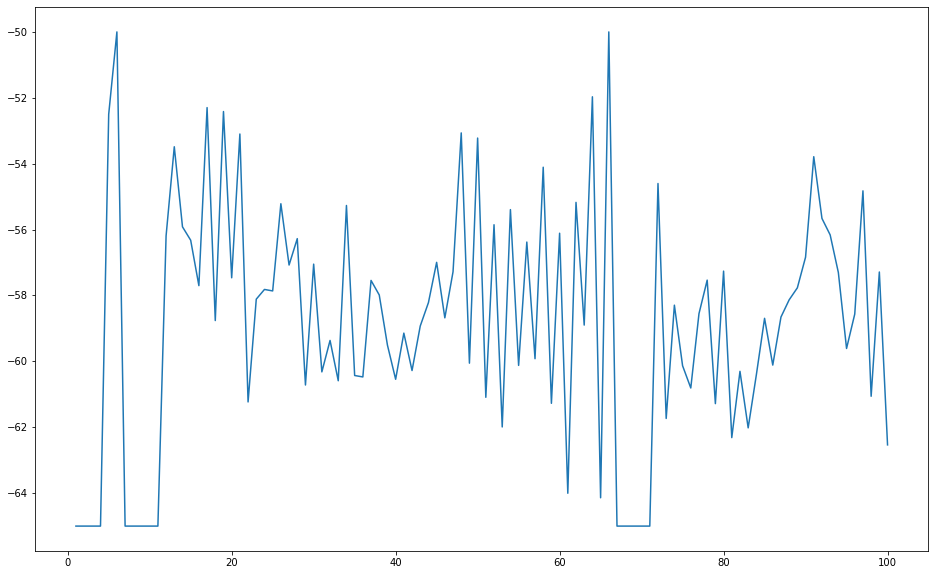

In [36]:
plt.subplots(figsize=(16, 10))
plt.plot(x_out,y_out)  #画图
plt.show()#loss函数图